In [1]:
import sys
sys.path.append('../')

In [2]:
import os
import sys
import json
import time
import rich
import numpy as np
import pickle
import wandb
import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

from configs.finetune import FinetuneConfig
from tasks.classification import Classification

from models.backbone.base import calculate_out_features
from models.backbone.densenet import DenseNetBackbone
from models.backbone.resnet import build_resnet_backbone
from models.head.projector import MLPHead

from datasets.brain import BrainProcessor, Brain, BrainMoCo
from datasets.transforms import make_transforms, compute_statistics

from utils.logging import get_rich_logger
from utils.gpu import set_gpu

In [3]:
from easydict import EasyDict as edict
from torch.utils.data import DataLoader
from utils.metrics import classification_result

import collections
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [4]:
@torch.no_grad()
def extract_features(data_loader, backbone, projector, device, use_projector=True):

    backbone.to(device)
    backbone.eval()
    projector.to(device)
    projector.eval()

    reprs, labels = [], []
    for batch in tqdm.tqdm(data_loader):
        if use_projector:
            z = projector(backbone(batch['x'].to(device, non_blocking=True)))        
            reprs += [F.normalize(z, dim=1)]
        else:
            z = backbone(batch['x'].to(device, non_blocking=True))
            z = nn.Flatten()(nn.AdaptiveAvgPool3d(1)(z))
            reprs += [z]
        labels += [batch['y'].to(device)]
    
    reprs = torch.cat(reprs, dim=0).cpu().numpy()
    labels = torch.cat(labels, dim=0).cpu().numpy()

    backbone.to('cpu')
    projector.to('cpu')

    return reprs, labels

In [5]:
hashs = ["2022-07-02_18-54-27", "2022-07-02_18-53-46", "2022-07-02_17-15-34",
         "2022-07-02_17-15-14", "2022-07-02_11-20-21", "2022-07-02_11-17-38",
         "2022-07-02_09-40-42", "2022-07-02_09-38-52", "2022-07-02_08-00-57", "2022-07-02_08-00-31"]

In [6]:
result_list = []

server = 'dgx'
gpus = ['3']

In [7]:
for i, hash in enumerate(hashs):
    
    print('--------------------------------- ', i, ' ---------------------------------')
    
    # set config
    config = edict()
    config.pretrained_file_prefix = '../checkpoints/pet-supmoco/resnet/'
    config.server = server
    config.gpus = gpus
    local_rank = 0
    
    # load pretrained model's config
    config.pretrained_dir = f'{config.pretrained_file_prefix}{hash}'
    config.pretrained_file = os.path.join(config.pretrained_dir, "ckpt.last.pth.tar")

    pretrained_config = os.path.join(config.pretrained_dir, "configs.json")
    with open(pretrained_config, 'rb') as fb:
        pretrained_config = json.load(fb)

    pretrained_config_names = [
        # data_parser
        'data_type', 'root', 'data_info', 'mci_only', 'n_splits', 'n_cv',
        'image_size', 'small_kernel', 'random_state',
        'intensity', 'crop', 'crop_size', 'rotate', 'flip', 'affine', 'blur', 'blur_std', 'prob',
        # model_parser
        'backbone_type', 'init_features', 'growth_rate', 'block_config', 'bn_size', 'dropout_rate',
        'arch', 'no_max_pool',
        # train
        'batch_size',
        # moco / supmoco
        'alphas',
        # others
        'task', 'projector_dim'
    ]

    for name in pretrained_config_names:
        if name in pretrained_config.keys():
            setattr(config, name, pretrained_config[name])
    
    set_gpu(config)
    np.random.seed(config.random_state)
    torch.manual_seed(config.random_state)
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.allow_tf32 = True
    torch.cuda.set_device(local_rank)
    
    # Networks
    if config.backbone_type == 'densenet':
        backbone = DenseNetBackbone(in_channels=1,
                                    init_features=config.init_features,
                                    growth_rate=config.growth_rate,
                                    block_config=config.block_config,
                                    bn_size=config.bn_size,
                                    dropout_rate=config.dropout_rate,
                                    semi=False)
        activation = True
    elif config.backbone_type == 'resnet':
        backbone = build_resnet_backbone(arch=config.arch,
                                         no_max_pool=config.no_max_pool,
                                         in_channels=1,
                                         semi=False)
        activation = False
    else:
        raise NotImplementedError

    if config.small_kernel:
        backbone._fix_first_conv()

    if config.crop:
        out_dim = calculate_out_features(backbone=backbone, in_channels=1, image_size=config.crop_size)
    else:
        out_dim = calculate_out_features(backbone=backbone, in_channels=1, image_size=config.image_size)
    projector = MLPHead(out_dim, config.projector_dim)    

    backbone.load_weights_from_checkpoint(path=config.pretrained_file, key='backbone')
    projector.load_weights_from_checkpoint(path=config.pretrained_file, key='head')
    
    # load finetune data
    data_processor = BrainProcessor(root=config.root,
                                    data_info=config.data_info,
                                    data_type=config.data_type,
                                    mci_only=config.mci_only,
                                    random_state=config.random_state)
    datasets = data_processor.process(n_splits=config.n_splits, n_cv=config.n_cv)

    # intensity normalization
    assert config.intensity in [None, 'scale', 'minmax']
    mean_std, min_max = (None, None), (None, None)
    if config.intensity is None:
        pass
    elif config.intensity == 'scale':
        pass
    elif config.intensity == 'minmax':
        with open(os.path.join(config.root, 'labels/minmax.pkl'), 'rb') as fb:
            minmax_stats = pickle.load(fb)
            min_max = (minmax_stats[config.data_type]['min'], minmax_stats[config.data_type]['max'])
    else:
        raise NotImplementedError

    train_transform, test_transform = make_transforms(image_size=config.image_size,
                                                      intensity=config.intensity,
                                                      mean_std=mean_std,
                                                      min_max=min_max,
                                                      crop=config.crop,
                                                      crop_size=config.crop_size,
                                                      rotate=config.rotate,
                                                      flip=config.flip,
                                                      affine=config.affine,
                                                      blur=config.blur,
                                                      blur_std=config.blur_std,
                                                      prob=config.prob)

    train_set = Brain(dataset=datasets['train'], data_type=config.data_type, transform=test_transform)
    test_set = Brain(dataset=datasets['test'], data_type=config.data_type, transform=test_transform)

    train_loader = DataLoader(dataset=train_set, batch_size=16, drop_last=False)
    test_loader = DataLoader(dataset=test_set, batch_size=16, drop_last=False)
    
    for use_projector in [True, False]:
        train_reprs, train_labels = extract_features(train_loader, backbone, projector, local_rank, use_projector)
        test_reprs, test_labels = extract_features(test_loader, backbone, projector, local_rank, use_projector)
        
        #
        model = GradientBoostingClassifier(n_estimators=100)
        model.fit(train_reprs, train_labels)
        y_pred = model.predict_proba(test_reprs)
        result = classification_result(torch.tensor(test_labels), torch.tensor(y_pred))
        
        result['projector'] = use_projector
        result['classifier'] = 'gbm'
        result['n_estimators'] = 100
        result['random_state'] = config.random_state
        
        result_list.append(result)
        del result
        
        #
        model = GradientBoostingClassifier(n_estimators=10)
        model.fit(train_reprs, train_labels)
        y_pred = model.predict_proba(test_reprs)
        result = classification_result(torch.tensor(test_labels), torch.tensor(y_pred))
        
        result['projector'] = use_projector
        result['classifier'] = 'gbm'
        result['n_estimators'] = 10
        result['random_state'] = config.random_state
        
        result_list.append(result)
        del result
        
        #
        model = RandomForestClassifier(n_estimators=100)
        model.fit(train_reprs, train_labels)
        y_pred = model.predict_proba(test_reprs)
        result = classification_result(torch.tensor(test_labels), torch.tensor(y_pred))
        
        result['projector'] = use_projector
        result['classifier'] = 'rf'
        result['n_estimators'] = 100
        result['random_state'] = config.random_state
        
        result_list.append(result)
        del result
        
        #
        model = RandomForestClassifier(n_estimators=10)
        model.fit(train_reprs, train_labels)
        y_pred = model.predict_proba(test_reprs)
        result = classification_result(torch.tensor(test_labels), torch.tensor(y_pred))
        
        result['projector'] = use_projector
        result['classifier'] = 'rf'
        result['n_estimators'] = 10
        result['random_state'] = config.random_state
        
        result_list.append(result)
        del result
        
        #
        model = DecisionTreeClassifier()
        model.fit(train_reprs, train_labels)
        y_pred = model.predict_proba(test_reprs)
        result = classification_result(torch.tensor(test_labels), torch.tensor(y_pred))
        
        result['projector'] = use_projector
        result['classifier'] = 'tree'
        result['n_estimators'] = 'none'
        result['random_state'] = config.random_state
        
        result_list.append(result)
        del result
        
        
        assert False

---------------------------------  0  ---------------------------------


100%|██████████| 4/4 [00:06<00:00,  1.52s/it]


AssertionError: 

In [42]:
model = RandomForestClassifier(n_estimators=100)
model.fit(train_reprs, train_labels)
y_pred = model.predict_proba(test_reprs)
print(classification_result(torch.tensor(test_labels), torch.tensor(y_pred), threshold=0.5))

{'acc': 0.8571428571428571, 'auroc': 0.7859476804733276, 'sens': 0.5833333284722223, 'spec': 0.9215686256439831, 'prec': 0.6363636305785125, 'f1': 0.6086955969754295, 'gmean': 0.7331996275315994}


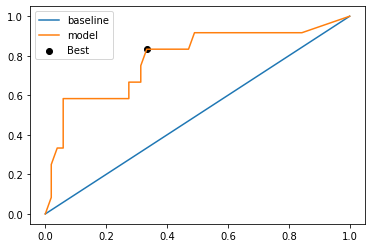

In [43]:
from sklearn.metrics import roc_curve

y_pred_conv = y_pred[:, 1]


fpr, tpr, thres = roc_curve(test_labels, y_pred_conv)
gmeans = np.sqrt(tpr * (1-fpr))
idx = np.argmax(gmeans)

import matplotlib.pyplot as plt
plt.plot([0, 1], [0, 1], label='baseline')
plt.plot(fpr, tpr, label='model')
plt.scatter(fpr[idx], tpr[idx], marker='o', color='black', label='Best')
plt.legend()
plt.show()

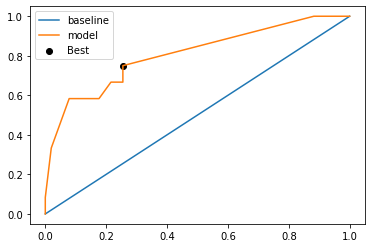

In [34]:
from sklearn.metrics import roc_curve

y_pred_conv = y_pred[:, 1]


fpr, tpr, thres = roc_curve(test_labels, y_pred_conv)

dist = fpr ** 2 + (1 - tpr) ** 2
idx = np.argmin(dist)


import matplotlib.pyplot as plt
plt.plot([0, 1], [0, 1], label='baseline')
plt.plot(fpr, tpr, label='model')
plt.scatter(fpr[idx], tpr[idx], marker='o', color='black', label='Best')
plt.legend()
plt.show()

In [44]:
a = confusion_matrix(torch.tensor(y_pred), torch.tensor(test_labels), 
                     num_classes=2, threshold=0.5)
b = confusion_matrix(torch.tensor(y_pred), torch.tensor(test_labels), 
                     num_classes=2, threshold=thres[idx])
print(a)
print(b)

tensor([[47,  4],
        [ 5,  7]])
tensor([[47,  4],
        [ 5,  7]])


In [52]:
confusion_matrix(preds=torch.tensor(y_pred), target=torch.tensor(test_labels), num_classes=2, threshold=0.5)

tensor([[47,  4],
        [ 5,  7]])

In [51]:
confusion_matrix(preds=torch.tensor(y_pred), target=torch.tensor(test_labels), num_classes=2, threshold=0.1)

tensor([[47,  4],
        [ 5,  7]])

In [61]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, y_pred[:, 1] > 0.5)

n00, n01, n10, n11 = cm.reshape(-1, ).tolist()

accuracy_ = (n00 + n11) / (n00 + n01 + n10 + n11)
sensitivity_ = n11 / (n11 + n10 + 1e-7)
specificity_ = n00 / (n00 + n01 + 1e-7)
precision_ = n11 / (n11 + n01 + 1e-7)
f1_ = (2 * precision_ * sensitivity_) / (precision_ + sensitivity_ + 1e-7)
gmean_ = np.sqrt(sensitivity_ * specificity_)

dict(sens=sensitivity_, spec=specificity_, prec=precision_,
     f1=f1_, gmean=gmean_)
accuracy_

0.8571428571428571

In [62]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, y_pred[:, 1] > 0.1)

n00, n01, n10, n11 = cm.reshape(-1, ).tolist()

accuracy_ = (n00 + n11) / (n00 + n01 + n10 + n11)
sensitivity_ = n11 / (n11 + n10 + 1e-7)
specificity_ = n00 / (n00 + n01 + 1e-7)
precision_ = n11 / (n11 + n01 + 1e-7)
f1_ = (2 * precision_ * sensitivity_) / (precision_ + sensitivity_ + 1e-7)
gmean_ = np.sqrt(sensitivity_ * specificity_)

dict(sens=sensitivity_, spec=specificity_, prec=precision_,
     f1=f1_, gmean=gmean_)
accuracy_

0.6507936507936508

In [54]:
confusion_matrix(test_labels, y_pred[:, 1] > 0.5)

array([[47,  4],
       [ 5,  7]])

In [ ]:
with open('../ml_result.pkl', 'wb') as fb:
    pickle.dump(result_list, fb)

In [ ]:
print(sum(datasets['train']['y'] == 1))
print(sum(datasets['test']['y'] == 1))

In [ ]:
print(sum(datasets['train']['y'] == 0))
print(sum(datasets['test']['y'] == 0))

In [ ]:
print(len(datasets['u_train']['y']))